In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

pd.set_option('display.max_columns', None)

In [2]:
train_data = pd.read_csv('./training.csv')
train, val = train_test_split(train_data, test_size=0.3, random_state=42)

df = train.copy()

In [3]:
# sprawdzamy, czy zmienna objaśniana została podzielona po równo
[train_data[train_data.IsBadBuy == 1].size / train_data.size,
 df[df.IsBadBuy == 1].size / df.size,
 val[val.IsBadBuy == 1].size / val.size]

[0.12298754504473644, 0.12317961165048544, 0.12253939255537794]

# Data Exploration

In [4]:
df.shape

(51088, 34)

In [5]:
df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
4518,4525,0,4/13/2010,MANHEIM,2007,3,CHEVROLET,IMPALA V6,LT,4D SEDAN LT 3.5L,WHITE,AUTO,1.0,Alloy,74124,AMERICAN,LARGE,GM,8743.0,10270.0,11926.0,13603.0,8167.0,9866.0,12135.0,13694.0,NaN,NaN,17675,2764,MA,7480.0,0,1974
9398,9407,0,6/15/2009,MANHEIM,2006,3,DODGE,STRATUS V6 2.7L V6 M,SXT,4D SEDAN SXT FFV,BLUE,AUTO,2.0,Covers,75312,AMERICAN,MEDIUM,CHRYSLER,5480.0,6461.0,6418.0,7478.0,5638.0,6512.0,6589.0,7533.0,NaN,NaN,18880,27542,NC,4700.0,0,1389
13852,13862,0,9/14/2010,MANHEIM,2007,3,FORD,ESCAPE 2WD 4C,XLS,4D CUV 2.3L XLS,BLUE,AUTO,1.0,Alloy,70699,AMERICAN,SMALL SUV,FORD,8460.0,10246.0,12297.0,13975.0,8223.0,10358.0,12126.0,14046.0,NaN,NaN,52646,21075,MD,7970.0,0,920
11511,11520,0,6/14/2010,MANHEIM,2006,4,FORD,TAURUS,SE,4D SEDAN SE,GREY,AUTO,1.0,Alloy,91573,AMERICAN,MEDIUM,FORD,4541.0,5759.0,7637.0,8842.0,4216.0,5578.0,7533.0,8973.0,NaN,NaN,18880,27542,NC,5200.0,0,1053
2186,2189,1,4/7/2009,ADESA,2006,3,FORD,FIVE HUNDRED 3.0L V6,SE,4D SEDAN SE,BEIGE,AUTO,NaN,NaN,76890,AMERICAN,LARGE,FORD,6266.0,7716.0,7267.0,8833.0,6266.0,7716.0,7267.0,8833.0,NaN,NaN,19619,45005,OH,6630.0,0,1506


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51088 entries, 4518 to 15795
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              51088 non-null  int64  
 1   IsBadBuy                           51088 non-null  int64  
 2   PurchDate                          51088 non-null  object 
 3   Auction                            51088 non-null  object 
 4   VehYear                            51088 non-null  int64  
 5   VehicleAge                         51088 non-null  int64  
 6   Make                               51088 non-null  object 
 7   Model                              51088 non-null  object 
 8   Trim                               49444 non-null  object 
 9   SubModel                           51083 non-null  object 
 10  Color                              51083 non-null  object 
 11  Transmission                       51083 non-null  

## IsBadBuy

Binarna zmienna objaśniana

In [7]:
df[df.IsBadBuy == 1].size / df.size

0.12317961165048544

Widać pewne niezbalansowanie

## PurchDate

Data zakupu samochodu na aukcji

In [8]:
df['PurchDate'] = pd.to_datetime(df['PurchDate'])
df['Year'] = df['PurchDate'].dt.year
df['Month'] = df['PurchDate'].dt.month
df['Day'] = df['PurchDate'].dt.day

In [9]:
df.groupby('Year')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Year,,
2010,0.130539,26651
2009,0.115153,24437


Mamy dwa lata zakupu - zrobimy z tego zmienną binarną

<AxesSubplot:>

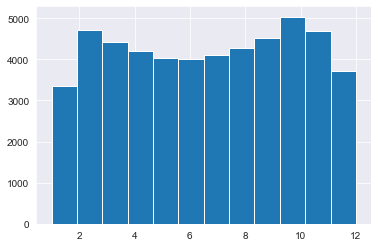

In [10]:
df.Month.hist(bins=12)

Zakupy odbywały się najczęściej w miesiącach jesiennych i wczesnowiosennych, rzadziej latem a najrzadziej na przełomie roku.

In [11]:
df.groupby('Month')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Month,,
3,0.144668,4417
9,0.137229,4518
12,0.133924,3726
2,0.130582,4725
8,0.129855,4274
1,0.129735,3353
4,0.125387,4195
11,0.118612,4696
6,0.111472,4001


Należy uwzględnić miesiąc zakupu

<AxesSubplot:>

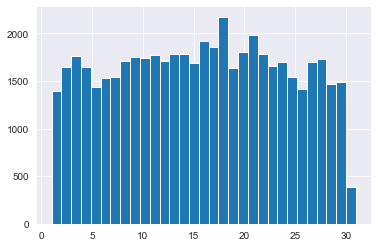

In [12]:
df.Day.hist(bins=31)

In [13]:
df.groupby('Day')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Day,,
31,0.149485,388
2,0.137994,1645
3,0.137813,1756
9,0.137793,1749
22,0.135546,1778
4,0.135036,1644
25,0.132858,1543
30,0.130816,1483
26,0.130650,1416


Z dni nie wynikają żadne interesujące zależności.

## Auction

Identyfikator dostawcy na aukcji, u którego samochód został kupiony

In [14]:
df.groupby('Auction')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
Auction,,
ADESA,0.150240,10197
MANHEIM,0.116916,28730
OTHER,0.115287,12161


Jest widoczna pewna zależność - uwzględnimy to

## VehYear

Rok produkcji samochodu

<AxesSubplot:>

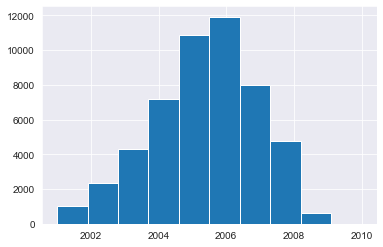

In [15]:
df.VehYear.hist()

In [16]:
df.groupby('VehYear')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False)

,mean,count
VehYear,,
2001,0.292113,1027
2002,0.237259,2335
2003,0.198102,4321
2004,0.160401,7182
2005,0.130028,10890
2006,0.092175,11923
2007,0.077856,8002
2008,0.056738,4794
2009,0.034258,613


Jak najbardziej istotna zmienna, ale być może lepiej będzie się zająć wiekiem pojazdu

## VehicleAge

Lata minione od roku produkcji

In [17]:
df.VehYear.corr(df.VehicleAge)

-0.9578157122805948

Bez zaskoczenia, usuniemy zatem rok produkcji, bo wiek wydaje się sensowniejszą zmienną.

## Make

Producent samochodu

In [18]:
df.groupby('Make')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Make,,
CHEVROLET,0.095506,12083
DODGE,0.102299,9003
FORD,0.152767,7986
CHRYSLER,0.126673,6126
PONTIAC,0.121856,3061
KIA,0.115642,1790
SATURN,0.154206,1498
NISSAN,0.157858,1419
HYUNDAI,0.126283,1267


Jak najbardziej istotna zmienna

## Model

Model samochodu

In [19]:
df.groupby('Model')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Model,,
PT CRUISER,0.187306,1607
IMPALA,0.073844,1449
TAURUS,0.146798,1015
CALIBER,0.102167,969
CARAVAN GRAND FWD V6,0.126596,940
...,...,...
MAGNUM V6 MFI V6 3.5,0.000000,1
MALIBU 4C 2.2L I-4 M,0.000000,1
F250 PICKUP 4WD V8,0.000000,1


In [20]:
df.groupby(['Make', 'Model'])['IsBadBuy'].agg(['count'])

count
Make       Model                      
ACURA      3.2 CL 3.2L V 6 NA S      3
           3.2 TL                    4
           3.2 TL 3.2L V6 EFI        1
           3.2 TL 3.2L V6 FI DO      1
           MDX 4WD                   3
...                                ...
VOLKSWAGEN JETTA 5C                 49
           PASSAT 4C                 1
           RABBIT                    2
VOLVO      S40                      28
           S60                       1

[1016 rows x 1 columns]

## Trim

Rodzaj pakietu

In [21]:
df.Trim.isnull().sum()

1644

Występuje tu sporo braków danych.

In [22]:
df.Trim.value_counts()

Bas    9800
LS     7130
SE     6521
SXT    2696
LT     2468
       ... 
Out       1
Maz       1
Si        1
Har       1
Dur       1
Name: Trim, Length: 130, dtype: int64

In [23]:
df.groupby('Trim')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Trim,,
Bas,0.124490,9800
LS,0.085554,7130
SE,0.119767,6521
SXT,0.103116,2696
LT,0.069692,2468
...,...,...
Har,0.000000,1
Si,0.000000,1
Dur,0.000000,1


Widać tu pewne zależności, ale jest bardzo dużo różnych rodzajów co może sprawić kłopot przy one hot encodingu. Do przemyślenia

## SubModel

Zmienna opisuje liczbę drzwi samochodu, rodzaj nadwozia, pakiet oraz pojemność silnika

In [24]:
df.SubModel.info()

<class 'pandas.core.series.Series'>
Int64Index: 51088 entries, 4518 to 15795
Series name: SubModel
Non-Null Count  Dtype 
--------------  ----- 
51083 non-null  object
dtypes: object(1)
memory usage: 798.2+ KB


Występuje tu całe 8 braków danych. Jakoś sobie chyba z tym poradzimy.

In [25]:
df.groupby('SubModel')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
SubModel,,
4D SEDAN,0.123179,10708
4D SEDAN LS,0.076317,3302
4D SEDAN SE,0.127691,2694
4D WAGON,0.100322,1555
MINIVAN 3.3L,0.091314,898
...,...,...
4D SPORT WAGON 2.5I,0.000000,1
EXT CAB 5.6L XE,0.000000,1
4D SPORT UTILITY TOURING NAV DVD,0.000000,1


Spróbujemy wydzielić z tej zmiennej liczbę drzwi, rodzaj nadwozia oraz pojemność silnika

## Color

Kolor sprzedawanego samochodu

In [26]:
df.groupby("Color")["IsBadBuy"].agg(["mean", "count"])

,mean,count
Color,,
BEIGE,0.137900,1124
BLACK,0.113008,5389
BLUE,0.114606,7312
BROWN,0.129568,301
GOLD,0.138336,3665
GREEN,0.130415,2193
GREY,0.114581,5507
MAROON,0.133615,1422
NOT AVAIL,0.253968,63


Wygląda na to ze not avaiable color zwiększa szanse zlego zakupu, zas pomaranczowy kolor w dziwny sposob zmniejsza - ale jest tam dosyc malo danych

In [27]:
df.groupby("Color")["VehBCost"].agg(["mean", "std", "count"])

,mean,std,count
Color,,,
BEIGE,6769.639680,1740.838270,1124
BLACK,7151.497148,1758.733180,5389
BLUE,6726.077463,1680.207982,7312
BROWN,6940.880399,1686.899119,301
GOLD,6389.958527,1722.330938,3665
GREEN,6477.834104,1719.664735,2193
GREY,7082.001997,1780.075683,5507
MAROON,6653.345105,1902.926241,1422
NOT AVAIL,6361.428571,1595.074937,63


Tutaj wygląda na to, że czarne samochody są droższe, niestandardowe kolory mają troche niższe ceny

Jeżeli chodzi o kolor wydaje się, że warto zwrócić uwagę na pomarańczowe samochody - coś tutaj jest nie w porządku.

Poniewaz kolumn jest malo, mozna zastosowac one hot encoding

## Transmission

Rodzaj skrzyni biegów

In [28]:
df.groupby("Transmission")["IsBadBuy"].agg(["mean", "count"])

,mean,count
Transmission,,
AUTO,0.123227,49275
MANUAL,0.121749,1807
Manual,0.000000,1


Wygląda na to, że transmission moze nie miec az tak duzego wplywu na zmienną. Wystarczy zakodować zmienną jako 0 lub jeden.

## WheelTypeId

ID typu kół

In [29]:
df[['WheelTypeID']].value_counts(dropna=False)

WheelTypeID
1.0            25293
2.0            23060
NaN             2196
3.0              535
0.0                4
dtype: int64

In [30]:
df.groupby('WheelTypeID')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False )

,mean,count
WheelTypeID,,
0.0,0.250000,4
3.0,0.132710,535
1.0,0.111217,25293
2.0,0.080486,23060


## WheelType

Typ kół

In [31]:
df[['WheelType']].value_counts(dropna=False)

WheelType
Alloy        25293
Covers       23060
NaN           2200
Special        535
dtype: int64

Usuwamy tą kolumnę - te same informacje co WheelTypeID

## VehOdo

Licznik - liczba przejechanych mil/kilometrów

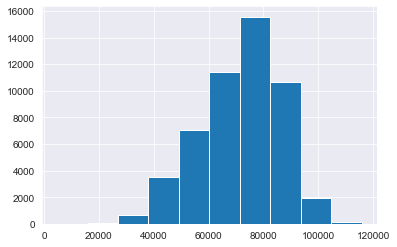

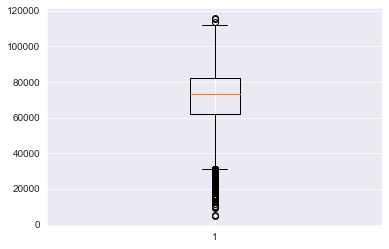

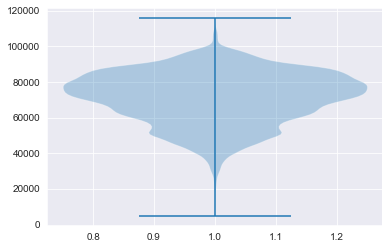

In [32]:
plt.hist(df['VehOdo'])
plt.show()

plt.boxplot(df['VehOdo'])
plt.show()

plt.violinplot(df['VehOdo'])
plt.show()

## Nationality

Gdzie samochód został wyprodukowany

In [33]:
df.groupby('Nationality')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False )

,mean,count
Nationality,,
OTHER,0.143836,146
OTHER ASIAN,0.135461,5640
TOP LINE ASIAN,0.133877,2577
AMERICAN,0.120854,42721


## Size

Rozmiar samochodu

In [34]:
df[['Size']].value_counts(dropna=False)

Size       
MEDIUM         21482
LARGE           6288
MEDIUM SUV      5688
COMPACT         5046
VAN             4093
LARGE TRUCK     2193
SMALL SUV       1569
SPECIALTY       1339
CROSSOVER       1233
LARGE SUV       1005
SMALL TRUCK      593
SPORTS           555
NaN                4
dtype: int64

In [35]:
df.groupby('Size')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False )

,mean,count
Size,,
SPORTS,0.185586,555
LARGE SUV,0.161194,1005
COMPACT,0.160721,5046
MEDIUM SUV,0.150316,5688
SMALL SUV,0.138942,1569
SMALL TRUCK,0.133221,593
VAN,0.125092,4093
MEDIUM,0.115539,21482
LARGE TRUCK,0.112175,2193


Ta kolumna moze miec kluczowe znaczenie dla modelu -> duże różnice w średnich

## TopThreeAmericanName

Zmienna opisująca czy producent należy do trzech największych amerykańskich producentów

In [36]:
df.groupby('TopThreeAmericanName')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False )

,mean,count
TopThreeAmericanName,,
FORD,0.155210,8685
OTHER,0.135119,8363
CHRYSLER,0.115683,16234
GM,0.108808,17802


Wyglada ze Ford ==> gorszy zakup

## MMR Columns

Zmienne opisujące ceny danego auta w różnych momentach i na różnych rynkach. Podobne do VehBCost - ceny samochodu na sprzedaż

<AxesSubplot:>

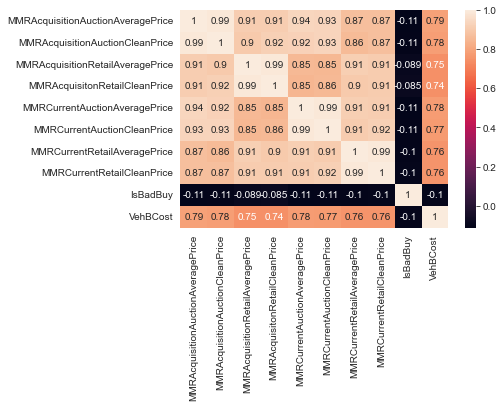

In [37]:
MMR_train = df.iloc[:, 18:26].join(df["IsBadBuy"]).join(df["VehBCost"])

sns.heatmap(MMR_train.corr(), annot=True)

okazują sie bardzo mocno skorelowane - wydaje się ze wystarczą najwyzej dwie z nich: *MMRAcquisitionAuctionAveragePrice* oraz *MMRCurrentAuctionAveragePrice* pozostałe są praktycznie identyczne

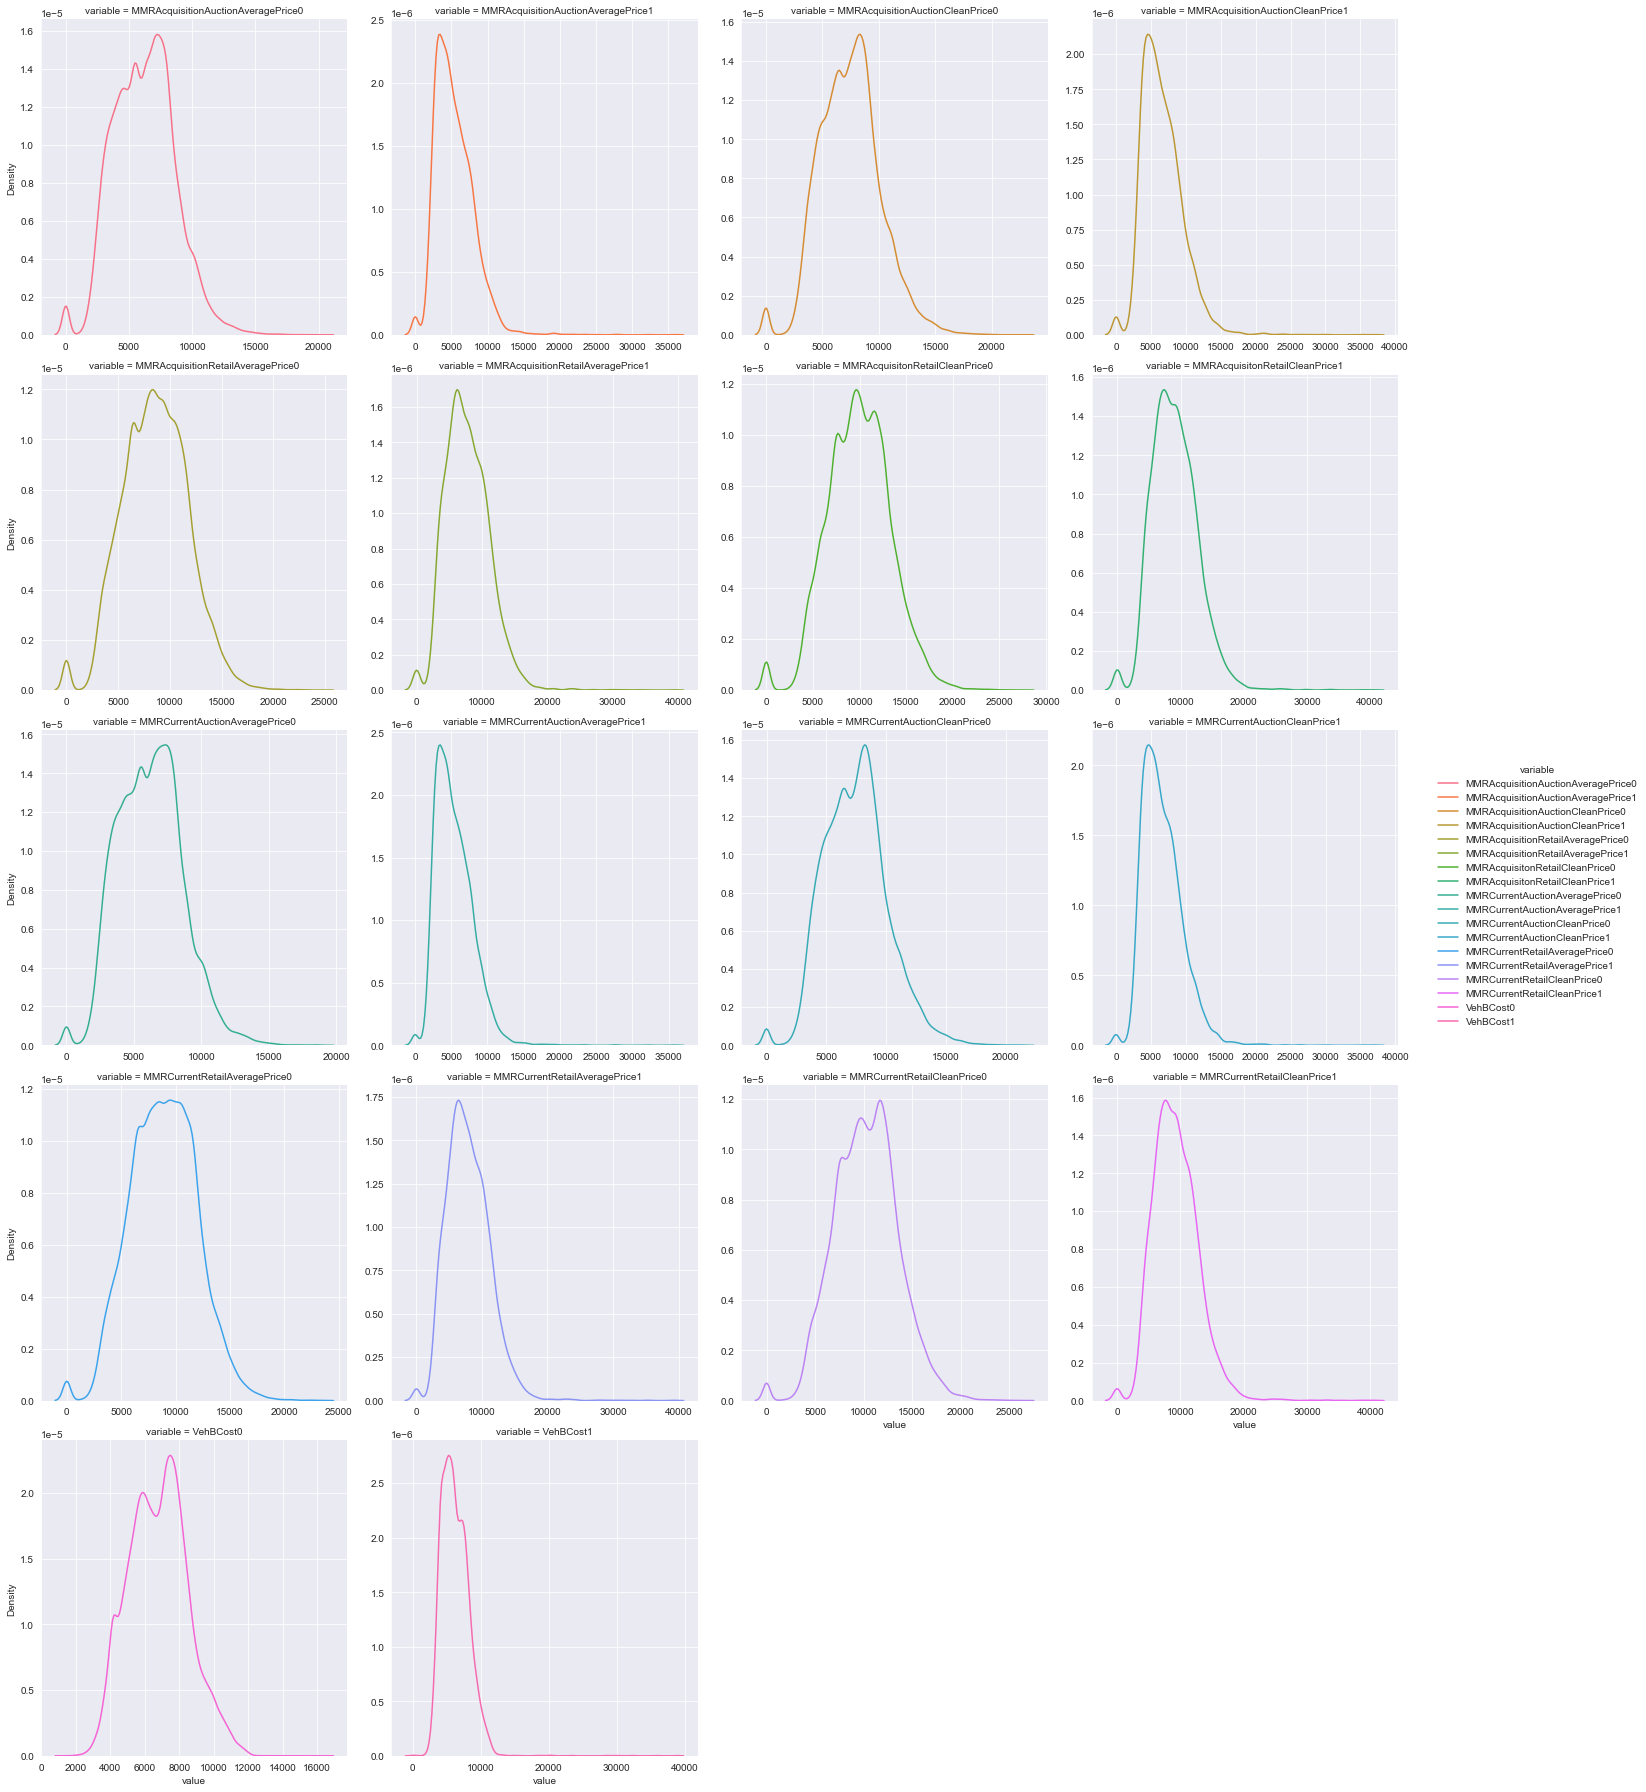

In [38]:
MMR_melt = MMR_train.melt(id_vars=['IsBadBuy'])

MMR_melt["variable"] = MMR_melt["variable"] + MMR_melt["IsBadBuy"].astype("str")

sns.displot(kind='kde', data=MMR_melt, col='variable', col_wrap=4, x='value', hue="variable", facet_kws={'sharey': False, 'sharex': False}) # wszystkie te wykresy wydają podobnie

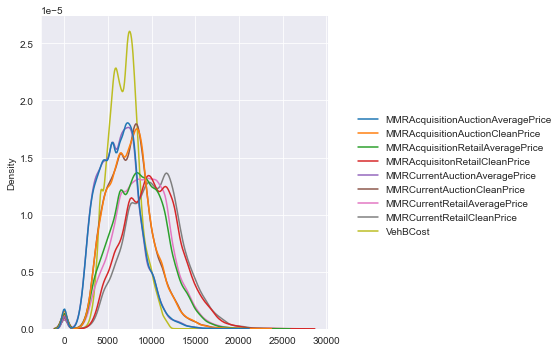

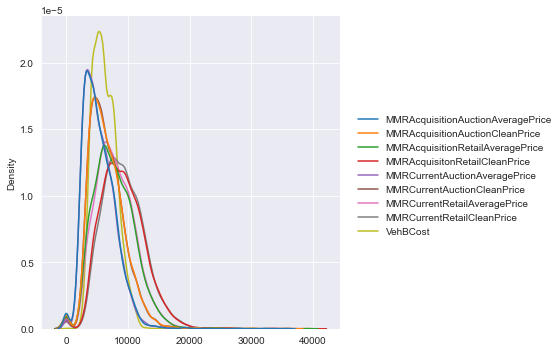

In [39]:
sns.displot(MMR_train.loc[MMR_train["IsBadBuy"]==0].loc[:, MMR_train.columns != "IsBadBuy"], kind="kde")
sns.displot(MMR_train.loc[MMR_train["IsBadBuy"]==1].loc[:, MMR_train.columns != "IsBadBuy"], kind="kde")
# bardzo duże powiązania między zmiennymi - tylko VehBCost sie wyróżnia

Zmienne te są bardzo skorelowane, istotne wydają się tylko dwie z nich, brak danych do poprawy - wartość 0 jest do zaimputowania, wygląda to jak tendencyjny brak danych a nie naturalna cena

## PRIMEUNIT

Czyli czy samochód jest bardziej premium i czy będzie na niego większe zapotrzebowanie

In [40]:
df["PRIMEUNIT"].isna().sum()

48697

In [41]:
df.groupby("PRIMEUNIT")["IsBadBuy"].agg(["mean", "count"])

,mean,count
PRIMEUNIT,,
NO,0.038889,2340
YES,0.098039,51


Dużo braków danych. Potrzebna będzie kolumna czy PRIMEUNIT jest nullem

## AUCGUART

Gwarancja zapewniona przez aukcję dla pojazdu

In [42]:
df.loc[df["PRIMEUNIT"].isna() == False]["AUCGUART"].isna().sum()

0

In [43]:
df.groupby("AUCGUART")["IsBadBuy"].agg(["mean", "count"])

,mean,count
AUCGUART,,
GREEN,0.038197,2330
RED,0.114754,61


In [44]:
df.groupby(["AUCGUART", "PRIMEUNIT"])["IsBadBuy"].agg(["mean", "count"])

mean  count
AUCGUART PRIMEUNIT                 
GREEN    NO         0.036858   2279
         YES        0.098039     51
RED      NO         0.114754     61

Jeżeli jest wpisany aucguart to primeunit tez. Mamy 3 możliwe wartości, ale nie ma środkowej - YELLOW

## BYRNO

ID kupującego

In [45]:
df.groupby("BYRNO").IsBadBuy.agg(["mean", "count"])

,mean,count
BYRNO,,
835,0.120172,2097
1031,0.052632,19
1035,0.142857,7
1041,0.200000,5
1045,0.239130,46
...,...,...
99740,0.132231,242
99741,1.000000,1
99750,0.027983,1894


<AxesSubplot:xlabel='BYRNO'>

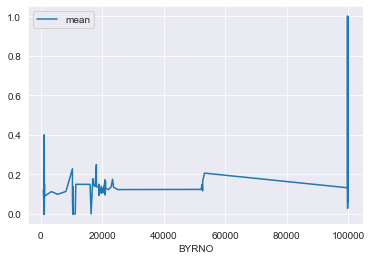

In [46]:
df.groupby("BYRNO").IsBadBuy.agg(["mean"]).plot()

In [47]:
df[["BYRNO", "IsBadBuy"]].corr() # w teorii brak korelacji

# wobec tego wydaje mi sie ze mozna usunąć kupującego - nieistotna kolumna

,BYRNO,IsBadBuy
BYRNO,1.000000,-0.061542
IsBadBuy,-0.061542,1.000000


## VNZIP1

Kod pocztowy miejsca w którym auto było kupione

In [48]:
df.groupby('VNZIP1')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False )

,mean,count
VNZIP1,,
46239,0.304348,92
60445,0.289157,83
17545,0.265306,98
37771,0.265306,294
79605,0.250000,96
...,...,...
32225,0.000000,4
32812,0.000000,39
70002,0.000000,11


In [49]:
counts = df['VNZIP1'].value_counts()
selected_categories = counts[counts > 1200].index
df[df['VNZIP1'].isin(selected_categories)].groupby('VNZIP1')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False )

,mean,count
VNZIP1,,
29697,0.156295,1382
28273,0.149142,1341
85226,0.143662,1420
75236,0.143544,1665
80022,0.129293,1485
95673,0.106430,1353
33619,0.104441,1216
27542,0.099629,2429
32824,0.095741,2559


## VNST

Stan w którym auto zostało kupione

In [50]:
df[['VNST']].value_counts()

VNST
TX      9493
FL      7280
NC      4963
CA      4943
AZ      4299
CO      3497
SC      2956
OK      2466
GA      1748
TN      1278
VA      1145
MD       810
UT       618
PA       606
OH       575
MO       529
AL       476
NV       417
MS       362
IN       355
IA       352
IL       321
LA       244
NJ       230
WV       187
NM       172
KY       168
OR       150
ID       144
WA       101
NH        65
AR        56
MN        41
NE        18
MA        11
MI         8
NY         4
dtype: int64

In [51]:
counts = df['VNST'].value_counts()
selected_categories = counts[counts > 1200].index
df[df['VNST'].isin(selected_categories)].groupby('VNST')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False )

,mean,count
VNST,,
SC,0.140054,2956
TX,0.136943,9493
CA,0.134736,4943
TN,0.125196,1278
CO,0.124964,3497
NC,0.117066,4963
AZ,0.111421,4299
FL,0.111126,7280
GA,0.108124,1748


## VehBCost

Koszt nabycia

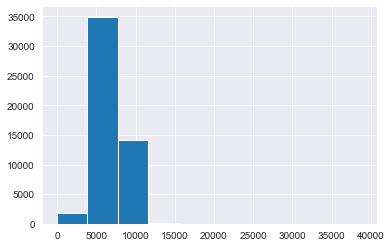

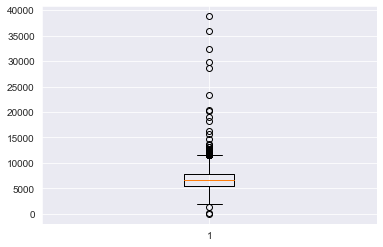

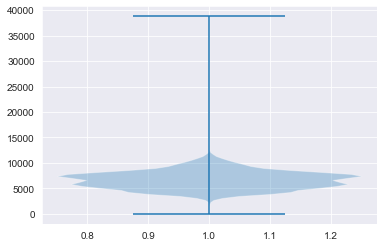

In [52]:
plt.hist(df['VehBCost'])
plt.show()

plt.boxplot(df['VehBCost'])
plt.show()

plt.violinplot(df['VehBCost'])
plt.show()

## IsOnlineSale

Czy samochód został kupiony online

In [53]:
df[['IsOnlineSale']].value_counts()

IsOnlineSale
0               49778
1                1310
dtype: int64

In [54]:
df.groupby('IsOnlineSale')['IsBadBuy'].agg(['mean','count']).sort_values('mean',ascending = False )

,mean,count
IsOnlineSale,,
0,0.123348,49778
1,0.116794,1310


Wiekszosc kupione nie online, średnia podobna

## WarrantyCost

Koszt ubezpieczenia

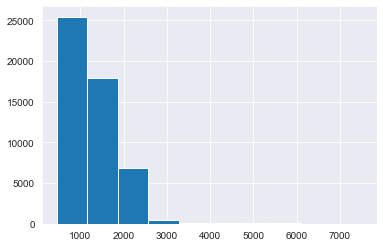

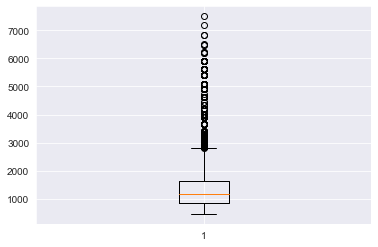

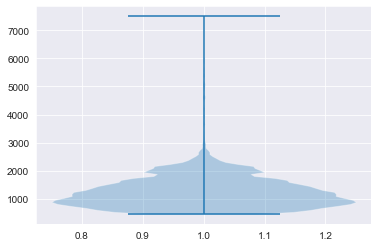

In [55]:
plt.hist(df['WarrantyCost'])
plt.show()

plt.boxplot(df['WarrantyCost'])
plt.show()

plt.violinplot(df['WarrantyCost'])
plt.show()

# Preprocessing

Dokonujemy przetworzenia danych zgodnie z wnioskami wyciągniętymi z EDA

In [56]:
# usuwamy te marki, bo mamy dla nich tylko po 1 lub 2 obserwacje
df = df.loc[~df['Make'].isin(["HUMMER", "PLYMOUTH", "TOYOTA SCION"]), :]

In [57]:
# zmiana na zmienną binarną
df['Year'] = df['Year'].apply(lambda x: x == 2010).astype(int)

In [58]:
# funkcja przypisująca porę roku
def assign_season(df):

    if 3 <= df['Month'] <= 5: val = 'Spring'
    elif 6 <= df['Month'] <= 8: val = 'Summer'
    elif 9 <= df['Month'] <= 11: val = 'Autumn'
    else: val = 'Winter'

    return val

In [59]:
# tworzymy zmienną pora roku
df['Season'] = df.apply(assign_season, axis = 1)
df.groupby('Season')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Season,,
Autumn,0.121263,14250
Spring,0.123428,12647
Summer,0.117248,12384
Winter,0.131396,11804


In [60]:
# wygiągamy liczbę drzwi ze zmiennej SubModel
df['Doors'] = df['SubModel'].str.extract(r'([1-9]D)').replace(np.nan, "UNKNOWN")
df.groupby('Doors')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Doors,,
4D,0.122306,41903
UNKNOWN,0.112465,6731
2D,0.163205,2359
5D,0.258621,58
3D,0.294118,34


In [61]:
# wygiągamy pojemność silnika ze zmiennej SubModel
df['Engine_size'] = df['SubModel'].str.extract(r'([1-9].[1-9])')
df.groupby('Engine_size')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Engine_size,,
3.5,0.062840,2021
4.2,0.118421,1672
3.3,0.103491,1633
4.7,0.108129,1267
3.9,0.115436,745
2.2,0.090535,729
4.6,0.162379,622
2.7,0.074576,590
3.8,0.187050,556


In [62]:
df.Engine_size.isna().sum()

# fajna sprawa z tą pojemnością, ale za dużo braków danych żeby ją rozpatrywać.

37435

In [63]:
# funkcja przypisująca rodzaj podwozia wyciągniętą ze zmiennej SubModel
df['SubModel'] = df['SubModel'].apply(lambda x: str(x).split())

def assign_chassis(df):

    types = ["CAB", "CONVERTIBLE", "CUV", "HATCHBACK", "PASSENGER", "SEDAN", "SPORT", "SUV", "MINIVAN", "UTILITY", "WAGON"]

    for word in df['SubModel']:
        if word in types:
            return word
    return "OTHER"

In [64]:
# tworzymy zmienną Chassis opisującą rodzaj podwozia
df['Chassis'] = df.apply(assign_chassis, axis=1)
df.groupby('Chassis')['IsBadBuy'].agg(['mean','count']).sort_values('count',ascending = False)

,mean,count
Chassis,,
SEDAN,0.116279,29627
SUV,0.134259,5832
WAGON,0.119377,2890
CAB,0.116864,2704
MINIVAN,0.121814,2315
OTHER,0.162189,2047
SPORT,0.151547,1907
PASSENGER,0.126256,1592
CUV,0.124082,1225


In [65]:
# dodajemy kolumne czy kolor jest bardziej niebezpieczny czy nie
color_train = df.groupby("Color")["IsBadBuy"].agg(["mean"])

max_mean_color = color_train["mean"].max()
color_dict = color_train["mean"].to_dict()
df["ColorDanger"] = df["Color"].map(color_dict).fillna(df.IsBadBuy.mean()) / max_mean_color
bad_colors = list(color_train.loc[color_train["mean"] > df.IsBadBuy.mean()].index)

df['DangerousColor'] = np.where(df["Color"].isin(bad_colors), 1, 0)
df[["ColorDanger", "Color"]].describe()

,ColorDanger
count,51085.000000
mean,0.484942
std,0.038725
min,0.315549
25%,0.451323
50%,0.487956
75%,0.513509
max,1.000000


In [66]:
color_dict

{'BEIGE': 0.13790035587188612,
 'BLACK': 0.11302895322939867,
 'BLUE': 0.11462180276295993,
 'BROWN': 0.12956810631229235,
 'GOLD': 0.1381004366812227,
 'GREEN': 0.13041495668034656,
 'GREY': 0.11458144180134375,
 'MAROON': 0.13361462728551335,
 'NOT AVAIL': 0.25396825396825395,
 'ORANGE': 0.08013937282229965,
 'OTHER': 0.125,
 'PURPLE': 0.14225941422594143,
 'RED': 0.13249942089413944,
 'SILVER': 0.12392543224186227,
 'WHITE': 0.12428387700222145,
 'YELLOW': 0.13218390804597702}

In [67]:
val["ColorDanger"] = val["Color"].map(color_dict).fillna(df.IsBadBuy.mean()).astype("float")

In [68]:
transmission_dict = {'AUTO':0, 'MANUAL':1}

df['Transmission'] = df['Transmission'].str.upper().map(transmission_dict)

In [69]:
df["IsPrimeunitNA"] = np.where(df["PRIMEUNIT"].isna(), 1, 0)

primeunit_dict = {'NO':0, 'YES':1, float("nan"):0}
df['PRIMEUNIT'] = df['PRIMEUNIT'].str.upper().map(primeunit_dict)


aucguart_dict = {'GREEN':2, 'YELLOW':1, "RED":0, float("nan"):0}
df['AUCGUART'] = df['AUCGUART'].str.upper().map(aucguart_dict)

In [70]:
df.drop(columns=["BYRNO"], inplace=True)

In [71]:
df[["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51085 entries, 4518 to 15795
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   MMRCurrentAuctionAveragePrice      50865 non-null  float64
 1   MMRAcquisitionAuctionAveragePrice  51074 non-null  float64
 2   VehBCost                           51085 non-null  float64
dtypes: float64(3)
memory usage: 1.6 MB


In [72]:
# zaimputujemy wartość 0 dla kolumn MMRCurrentAuctionAveragePrice oraz MMRAcquisitionAuctionAveragePrice
# pozostałe usuwamy
df["MMRCurrentAuctionAveragePrice"] = np.where(df["MMRCurrentAuctionAveragePrice"] == 0, np.nan, df["MMRCurrentAuctionAveragePrice"])
df["MMRAcquisitionAuctionAveragePrice"] = np.where(df["MMRAcquisitionAuctionAveragePrice"] == 0, np.nan, df["MMRAcquisitionAuctionAveragePrice"])

imp_mean = IterativeImputer(random_state=0)

MMR_columns = ["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]

imp_mean.fit(df[["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]])

MMR_train_transformed = imp_mean.transform(df[["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]])
MMR_train_transformed = pd.DataFrame(MMR_train_transformed, columns = ["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"])
MMR_train_transformed.index = df.index
MMR_train_transformed = MMR_train_transformed.join(df["IsBadBuy"])
MMR_train_transformed

,MMRCurrentAuctionAveragePrice,MMRAcquisitionAuctionAveragePrice,VehBCost,IsBadBuy
4518,8167.0,8743.0,7480.0,0
9398,5638.0,5480.0,4700.0,0
13852,8223.0,8460.0,7970.0,0
11511,4216.0,4541.0,5200.0,0
2186,6266.0,6266.0,6630.0,1
...,...,...,...,...
37194,7612.0,7471.0,8300.0,1
6265,4194.0,5768.0,7045.0,0
54886,6736.0,7162.0,6700.0,0
860,7148.0,7091.0,7295.0,0


## Przygotowanie danych

Powyższe przekształcenia miały charakter poglądowy - tutaj zamykamy to w funkcje, pipeline'y i transformery

In [151]:
train_df = pd.read_csv('./training.csv')
train, val = train_test_split(train_df, test_size=0.3, random_state=42)

In [152]:
X = train_df.drop('IsBadBuy', axis=1)
y = train_df.IsBadBuy

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [153]:
X_train

,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
4518,4525,4/13/2010,MANHEIM,2007,3,CHEVROLET,IMPALA V6,LT,4D SEDAN LT 3.5L,WHITE,AUTO,1.0,Alloy,74124,AMERICAN,LARGE,GM,8743.0,10270.0,11926.0,13603.0,8167.0,9866.0,12135.0,13694.0,NaN,NaN,17675,2764,MA,7480.0,0,1974
9398,9407,6/15/2009,MANHEIM,2006,3,DODGE,STRATUS V6 2.7L V6 M,SXT,4D SEDAN SXT FFV,BLUE,AUTO,2.0,Covers,75312,AMERICAN,MEDIUM,CHRYSLER,5480.0,6461.0,6418.0,7478.0,5638.0,6512.0,6589.0,7533.0,NaN,NaN,18880,27542,NC,4700.0,0,1389
13852,13862,9/14/2010,MANHEIM,2007,3,FORD,ESCAPE 2WD 4C,XLS,4D CUV 2.3L XLS,BLUE,AUTO,1.0,Alloy,70699,AMERICAN,SMALL SUV,FORD,8460.0,10246.0,12297.0,13975.0,8223.0,10358.0,12126.0,14046.0,NaN,NaN,52646,21075,MD,7970.0,0,920
11511,11520,6/14/2010,MANHEIM,2006,4,FORD,TAURUS,SE,4D SEDAN SE,GREY,AUTO,1.0,Alloy,91573,AMERICAN,MEDIUM,FORD,4541.0,5759.0,7637.0,8842.0,4216.0,5578.0,7533.0,8973.0,NaN,NaN,18880,27542,NC,5200.0,0,1053
2186,2189,4/7/2009,ADESA,2006,3,FORD,FIVE HUNDRED 3.0L V6,SE,4D SEDAN SE,BEIGE,AUTO,NaN,NaN,76890,AMERICAN,LARGE,FORD,6266.0,7716.0,7267.0,8833.0,6266.0,7716.0,7267.0,8833.0,NaN,NaN,19619,45005,OH,6630.0,0,1506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,37217,6/8/2010,MANHEIM,2007,3,CHRYSLER,SEBRING V6,Bas,4D SEDAN,BLUE,AUTO,2.0,Covers,67452,AMERICAN,MEDIUM,CHRYSLER,7471.0,8455.0,10916.0,11881.0,7612.0,8615.0,10763.0,11962.0,NaN,NaN,99750,46803,IN,8300.0,0,1118
6265,6272,4/29/2010,MANHEIM,2006,4,KIA,SPECTRA,EX,4D SEDAN,SILVER,AUTO,1.0,Alloy,67182,OTHER ASIAN,MEDIUM,OTHER,5768.0,6561.0,9019.0,9670.0,4194.0,5611.0,7125.0,8957.0,NaN,NaN,18881,30272,GA,7045.0,0,533
54886,54914,7/9/2010,OTHER,2006,4,CHEVROLET,MALIBU 4C,LT,4D SEDAN LT,SILVER,AUTO,1.0,Alloy,89342,AMERICAN,MEDIUM,GM,7162.0,8268.0,10348.0,11125.0,6736.0,8347.0,10068.0,11984.0,NaN,NaN,99750,73108,OK,6700.0,0,1113
860,862,9/29/2009,ADESA,2006,3,PONTIAC,G6 V6 3.5L V6 SFI,Bas,4D SEDAN,RED,AUTO,1.0,Alloy,78991,AMERICAN,MEDIUM,GM,7091.0,8581.0,8158.0,9767.0,7148.0,8389.0,10401.0,12057.0,NaN,NaN,99740,50111,IA,7295.0,0,1272


In [154]:
color_train = train.groupby("Color")["IsBadBuy"].agg(["mean"])
max_mean_color = color_train["mean"].max()
color_dict = color_train["mean"].to_dict()

imp_mean = IterativeImputer(random_state=42).fit(train[["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]])

train_bad_buy_mean = train.IsBadBuy.mean()

In [155]:
def assign_chassis(df):

    types = ["CAB", "CONVERTIBLE", "CUV", "HATCHBACK", "PASSENGER", "SEDAN", "SPORT", "SUV", "MINIVAN", "UTILITY", "WAGON"]

    for word in df['SubModel_splited']:
        if word in types:
            return word
    return "OTHER"

def assign_season(df):

    if 3 <= df['Month'] <= 5: val = 'Spring'
    elif 6 <= df['Month'] <= 8: val = 'Summer'
    elif 9 <= df['Month'] <= 11: val = 'Autumn'
    else: val = 'Winter'

    return val

def preprocess(df):

    df['PurchDate'] = pd.to_datetime(df['PurchDate'])
    df['Month'] = df['PurchDate'].dt.month
    df['Year'] = df['PurchDate'].dt.year.apply(lambda x: x == 2010).astype(int)
    df['Season'] = df.apply(assign_season, axis = 1)
    df['Doors'] = df['SubModel'].str.extract(r'([1-9]D)').replace(np.nan, "UNKNOWN")
    df['SubModel_splited'] = df['SubModel'].apply(lambda x: str(x).split())
    df['Chassis'] = df.apply(assign_chassis, axis=1)

    df['TopThreeAmericanName'] = df['TopThreeAmericanName'].fillna('OTHER')
    df['Size'] = df['Size'].fillna('MEDIUM')
    df['Nationality'] = df['Nationality'].fillna('OTHER')
    df['WheelType'] = df['WheelType'].fillna('OTHER')

    df["MMRCurrentAuctionAveragePrice"] = np.where(df["MMRCurrentAuctionAveragePrice"] == 0, np.nan, df["MMRCurrentAuctionAveragePrice"])
    df["MMRAcquisitionAuctionAveragePrice"] = np.where(df["MMRAcquisitionAuctionAveragePrice"] == 0, np.nan, df["MMRAcquisitionAuctionAveragePrice"])

    MMR_df = imp_mean.transform(df[["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]])
    MMR_df = pd.DataFrame(MMR_df, columns = ["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"])
    MMR_df.index = df.index
    df["MMRCurrentAuctionAveragePrice"] = MMR_df["MMRCurrentAuctionAveragePrice"]
    df["MMRAcquisitionAuctionAveragePrice"] = MMR_df["MMRAcquisitionAuctionAveragePrice"]

    df["ColorDanger"] = df["Color"].map(color_dict).fillna(train_bad_buy_mean)/max_mean_color

    df["IsPrimeunitNA"] = np.where(df["PRIMEUNIT"].isna(), 1, 0)
    df['PRIMEUNIT'] = df['PRIMEUNIT'].str.upper().map({'NO':0, 'YES':1, float("nan"):0})
    df['AUCGUART'] = df['AUCGUART'].str.upper().map({'GREEN':2, 'YELLOW':1, "RED":0, float("nan"):0})

    df['Transmission'] = df['Transmission'].str.upper().map({'AUTO':0, 'MANUAL':1})
    df["Transmission"] = df["Transmission"].fillna(df["Transmission"].median())

    return df

In [156]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['VehOdo','VehBCost', 'WarrantyCost', 'VehicleAge', 'MMRAcquisitionAuctionAveragePrice', 'MMRCurrentAuctionAveragePrice', 'ColorDanger']),
        ('passthrough','passthrough', ['IsOnlineSale', 'Year', 'IsPrimeunitNA', 'PRIMEUNIT', 'AUCGUART']),
        ('cat', OneHotEncoder(sparse_output=False),  ['WheelType', 'TopThreeAmericanName', 'Nationality','Size', 'Make', 'Chassis', 'Doors', 'Auction', 'Season', 'Month']),
        ('drop', 'drop', ['RefId', 'VehYear', 'Model', 'Trim', 'SubModel', 'WheelTypeID', "BYRNO", "Color", 'VNZIP1','VNST', "MMRAcquisitionAuctionCleanPrice", "MMRAcquisitionRetailAveragePrice", "MMRAcquisitonRetailCleanPrice","MMRCurrentAuctionCleanPrice", "MMRCurrentRetailAveragePrice", "MMRCurrentRetailCleanPrice"])
    ])

In [157]:
prepipe = Pipeline([("prepipe", FunctionTransformer(preprocess))])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [158]:
X_train = prepipe.fit_transform(X_train)
X_train = pipeline.fit_transform(X_train)

In [159]:
X_val = prepipe.transform(X_val)
X_val = pipeline.transform(X_val)

In [160]:
X_whole = prepipe.transform(X.copy())
X_whole = pipeline.transform(X_whole.copy())

In [161]:
colnames = pd.Index(['VehOdo','VehBCost', 'WarrantyCost', 'VehicleAge', 'MMRAcquisitionAuctionAveragePrice',
                     'MMRCurrentAuctionAveragePrice', 'ColorDanger'] + ['IsOnlineSale', 'Year', 'IsPrimeunitNA', 'PRIMEUNIT', 'AUCGUART']).append(pd.Index(preprocessor.named_transformers_['cat'].get_feature_names_out(['WheelType', 'TopThreeAmericanName','Nationality','Size', 'Make', 'Chassis', 'Doors', 'Auction', 'Season', 'Month'])))

In [162]:
X_train = pd.DataFrame(X_train, columns=colnames)
X_val = pd.DataFrame(X_val, columns=colnames)
X_whole = pd.DataFrame(X_whole, columns=colnames)

In [163]:
y_train.to_csv("./preprocessed_data/y_train.csv", index=False)
y.to_csv("./preprocessed_data/y_whole.csv", index=False)
y_val.to_csv("./preprocessed_data/y_val.csv", index=False)

In [164]:
X_train.to_csv("./preprocessed_data/X_train.csv", index=False)
X_whole.to_csv("./preprocessed_data/X_whole.csv", index=False)
X_val.to_csv("./preprocessed_data/X_val.csv", index=False)